# Projet I.A.

## Étude des données de HumanForYou

Pour commencer notre étude, nous allons d'abord importer les données fournies, les regrouper puis les étudier.

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from pandas import DataFrame, Series
import numpy as np

from datetime import datetime

from cmath import rect, phase
from math import radians, degrees

from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

#import scikitplot
#from scikitplot.metrics import plot_roc_curve as prc
#from scikitplot.metrics import plot_lift_curve as plc
#from scikitplot.metrics import plot_cumulative_gain as pcg
#from sklearn.metrics import classification_report

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
path = 'C:/Users/quent/OneDrive/Documents/GitHub/projet-ia/'

general = pd.read_csv(path + "general_data.csv")
employe = pd.read_csv(path + "employee_survey_data.csv")
manager = pd.read_csv(path + "manager_survey_data.csv")
In = pd.read_csv(path + "in_time.csv")
Out = pd.read_csv(path + "out_time.csv")

Avant toute chose, nous allons travailler sur les fichiers concernant les horaires de travail afin de les rendre utilisables.

Nous allons changer les NaN en 0 (ce qui correspond donc aux jours de congés) puis on vérifie que le nombre de jours de congés est bien le même dans les deux tables. On affiche ensuite un histogramme afin d'en retirer un aperçu plus visuel.

In [5]:
In.fillna(0, inplace=True)
Out.fillna(0, inplace=True)
vac_In = (In == 0).astype(int).sum(axis=1)
vac_Out = (Out ==0).astype(int).sum(axis=1)
 
vac_In.equals(vac_Out)

True

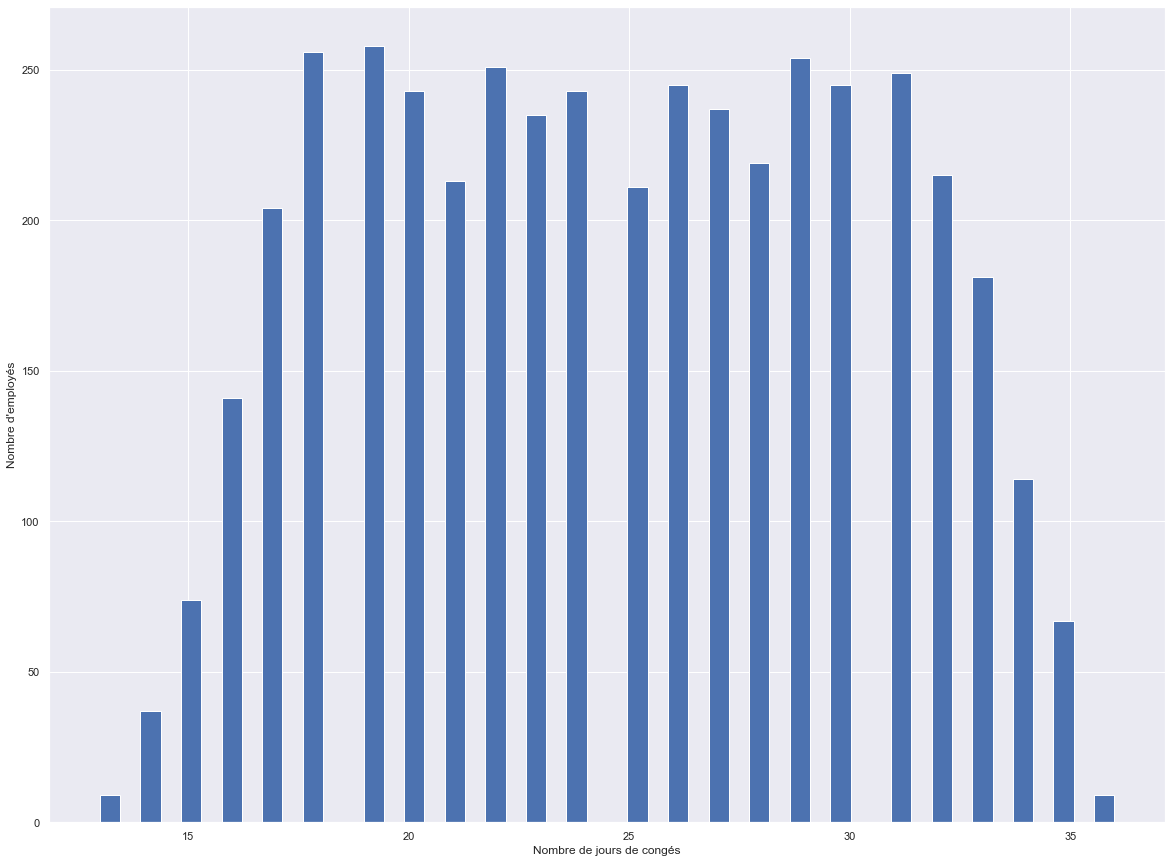

In [6]:
vac_In.hist(bins=50, figsize=(20,15))
plt.xlabel("Nombre de jours de congés")
plt.ylabel("Nombre d'employés")
plt.show()

On supprime la première colonne des deux tableaux car elle n'est pas utile.

In [7]:
In = In.drop(In.columns[0], axis = 1)
Out = Out.drop(Out.columns[0], axis = 1)

Nous allons maintenant transofrmer les données des tables In et Out en format datetime pour ensuite calculer l'heure moyenne d'arrivée et de départ des employés sur site.

In [8]:
In_h = In.iloc[:, 0:262].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S' )
Out_h = Out.iloc[:, 0:262].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S' )


def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mean_time(row):
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) 
               for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
Out_h['AverageInTime'] = Out_h.apply(mean_time, axis=1)

In [9]:
In_h['AverageInTime'].head()

0    10:00:05
1    09:59:17
2    10:01:30
3    09:58:54
4    09:59:54
Name: AverageInTime, dtype: object

Avec cela, on peut ensuite calculer le temps de travail moyen.

In [10]:
Average_Out = pd.to_timedelta(Out_h['AverageInTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = (Average_Out - Average_In)

print(AverageTimeWorking)

0      07:22:25
1      07:43:08
2      07:00:47
3      07:11:37
4      08:00:21
         ...   
4405   08:31:20
4406   06:05:34
4407   07:42:24
4408   09:29:34
4409   06:59:20
Name: AverageInTime, Length: 4410, dtype: timedelta64[ns]


On peut maintenant fusionner les csv restant et ajouter deux nouvelles colonnes : la première correspondant au nombre de jours de congés pris par l'employé, et la seconde au temps de travail moyen par jour de l'employé.

In [11]:
combined = general.merge(manager, how='right', on = 'EmployeeID')
combined_csv = combined.merge(employe, how='right', on = 'EmployeeID')
#On transforme tous les NA en 0
combined_csv.fillna(0, inplace=True)
combined_csv['AverageTimeWorking'] = AverageTimeWorking
combined_csv['Holidays'] = vac_In

combined_csv

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3,3,3.0,4.0,2.0,07:22:25,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,4,3.0,2.0,4.0,07:43:08,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,3,2.0,2.0,1.0,07:00:47,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,2,3,4.0,4.0,3.0,07:11:37,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,3,3,4.0,1.0,3.0,08:00:21,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,3,3,4.0,1.0,3.0,08:31:20,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,2,3,4.0,4.0,3.0,06:05:34,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,3,4,1.0,3.0,3.0,07:42:24,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,2,3,4.0,1.0,3.0,09:29:34,20


In [12]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   Age                      4410 non-null   int64          
 1   Attrition                4410 non-null   object         
 2   BusinessTravel           4410 non-null   object         
 3   Department               4410 non-null   object         
 4   DistanceFromHome         4410 non-null   int64          
 5   Education                4410 non-null   int64          
 6   EducationField           4410 non-null   object         
 7   EmployeeCount            4410 non-null   int64          
 8   EmployeeID               4410 non-null   int64          
 9   Gender                   4410 non-null   object         
 10  JobLevel                 4410 non-null   int64          
 11  JobRole                  4410 non-null   object         
 12  MaritalStatus       

On remarque que le temps de travail moyen n'est pas dans un format manipulable, nous allons donc le transofrmer en float.

In [13]:
Time_float = combined_csv['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageTimeWorking'] = Time_float

0       7.373611
1       7.718889
2       7.013056
3       7.193611
4       8.005833
          ...   
4405    8.522222
4406    6.092778
4407    7.706667
4408    9.492778
4409    6.988889
Name: AverageTimeWorking, Length: 4410, dtype: float64


In [14]:
print(combined_csv.dtypes)

Age                          int64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance     

Tout les types d'objets sont maintenant manipulables.

Une bonne idée serait maintenant d'identifier si certains employés travaillent trop, tandis que d'autres trop peu.
On pourrait ajouter une colonne indiquant si l'employé est normal, travaille peu ou se surmène.

In [15]:
combined_csv['AverageTimeWorking'].describe()

count    4410.000000
mean        7.700789
std         1.340222
min         5.950556
25%         6.673333
50%         7.406667
75%         8.368611
max        11.031389
Name: AverageTimeWorking, dtype: float64

On remarque effectivement que certains employés ont un temps de travail moyen de moins de 7h, ce qui est peu, tandis que d'autres sont bien au dessus de 8h (max 11h) ce qui représente du surmenage.

Nous allons donc créer une fonction qui va remplir une liste avec des booléens : 0 si l'employé travaille peu, 1 s'il est dans la norme et 2 s'il se surmène.

In [16]:
WorkingTimeEval = []
for i in range (0, combined_csv.shape[0]):
    if combined_csv['AverageTimeWorking'][i] < combined_csv['StandardHours'][i] :
        WorkingTimeEval.append(0)
    elif (combined_csv['AverageTimeWorking'][i] >= combined_csv['StandardHours'][i]) and (combined_csv['AverageTimeWorking'][i] <= 9):
        WorkingTimeEval.append(1)
    elif combined_csv['AverageTimeWorking'][i] > 9 :
        WorkingTimeEval.append(2)
WorkingTimeEval

[0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,


Notre liste est remplie, nous pouvons l'ajouter en tant que colonne dans notre set de données.

In [17]:
combined_csv['WorkingTimeEval'] = WorkingTimeEval
combined_csv

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


In [18]:
combined_csv['Attrition'].value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

Après concertation, nous avons décidé de supprimer les données Over18, EmployeeCount et EmployeeID. En effet, la première n'a pas de sens car tout les employés d'une entreprise doivent être majeure (sinon ce serai illégal et nous doutons que HumanForYou nous fournisse volontairement des données compromettantes). La seconde ne contient qu'une valeur dans notre dataset donc n'est pas utilisable. La dernière correspond à l'ID de l'employé, ce qui est inutile.

In [19]:
combined_csv = combined_csv.drop(columns=['EmployeeCount','Over18','EmployeeID'])

Comme vu dans l'étude sur l'attrition, 711 employés sur les 4410 sont partis en 2016.
On cherche à savoir pourquoi ces 711 employés ont quitté l'entreprise, nous allons donc dans un premier temps uniquement nous concentrer sur les données où l'Attrition est 'yes'.
Nous allons donc créer deux copies de notre set de données : le premier, combinedLeft, correspond uniquement aux employés étant partis en 2016; le second, combinedStay, à ceux restés.

In [20]:
combinedLeft = combined_csv.drop(combined_csv[combined_csv.Attrition == 'No'].index).copy()
combinedLeft.reset_index(drop=True, inplace=True)
combinedLeft

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
1,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,Male,2,Sales Executive,...,0,0,3,4,1.0,3.0,1.0,6.923611,29,0
2,47,Yes,Non-Travel,Research & Development,1,1,Medical,Male,1,Research Scientist,...,9,9,2,3,1.0,2.0,2.0,9.400000,26,2
3,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,Male,2,Research Scientist,...,0,0,2,3,4.0,3.0,1.0,10.977778,18,2
4,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,Male,3,Research Scientist,...,0,2,2,3,1.0,2.0,3.0,10.109444,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,Female,1,Research Scientist,...,0,1,3,4,3.0,4.0,2.0,8.406667,22,1
707,33,Yes,Travel_Rarely,Sales,11,4,Marketing,Male,1,Research Scientist,...,0,4,2,4,3.0,4.0,1.0,10.915278,28,2
708,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,Male,2,Manager,...,1,7,3,3,1.0,1.0,4.0,7.096944,31,0
709,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,Male,3,Healthcare Representative,...,1,2,3,3,4.0,3.0,1.0,10.176389,21,2


In [21]:
combinedStay = combined_csv.drop(combined_csv[combined_csv.Attrition == 'Yes'].index).copy()
combinedStay.reset_index(drop=True, inplace=True)
combinedStay

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
2,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
3,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
4,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,Female,4,Research Director,...,7,7,3,3,3.0,2.0,2.0,10.796111,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,42,No,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
3695,29,No,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
3696,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,Male,2,Sales Executive,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
3697,42,No,Travel_Rarely,Sales,18,2,Medical,Male,1,Laboratory Technician,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


Afin d'anticiper la numérisation de certaines données, nous allons créer des dictionnaires que nous utiliserons au moment opportun. 

In [22]:
diAttrition = {'No': 0, 'Yes': 1}
diBusinessTravel = {'Non-Travel': 0, 'Travel_Rarely':1, 'Travel_Frequently':2 }
diDepartment = {'Human Resources': 0, 'Sales': 1, 'Research & Development': 2}
diEducationField = {'Other': 0, 'Human Resources': 1, 'Technical Degree': 2, 'Marketing': 3, 'Medical': 4, 'Life Sciences': 5}
diJobRole = {'Human Resources': 0, 'Sales Representative': 1, 'Manager': 2, 'Manufacturing Director': 3, 
             'Healthcare Representative': 4, 'Research Director': 5, 'Laboratory Technician': 6, 'Research Scientist': 7,
             'Sales Executive': 8}
diGender = {'Male': 0, 'Female':1}
diMaritalStatus = {'Married': 0, 'Single': 1, 'Divorced':2}

### Étude des employés partis en 2016

Afin de pouvoir identifier d'éventuelles corrélations, nous allons, dans un DataFrame temporaire, numériser certaines valeurs afin de n'avoir que des valeurs numériques. Nous pouvons donc utiliser les dictionnaires mis en place précédemment avec du mapping.

On initialise la copie du DataFrame.

In [23]:
combinedLeftNum = combinedLeft.copy()
combinedLeftNum.reset_index(drop=True, inplace=True)
combinedLeftNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
1,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,Male,2,Sales Executive,...,0,0,3,4,1.0,3.0,1.0,6.923611,29,0
2,47,Yes,Non-Travel,Research & Development,1,1,Medical,Male,1,Research Scientist,...,9,9,2,3,1.0,2.0,2.0,9.400000,26,2
3,44,Yes,Travel_Frequently,Research & Development,1,2,Medical,Male,2,Research Scientist,...,0,0,2,3,4.0,3.0,1.0,10.977778,18,2
4,26,Yes,Travel_Rarely,Research & Development,4,3,Medical,Male,3,Research Scientist,...,0,2,2,3,1.0,2.0,3.0,10.109444,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,Yes,Travel_Rarely,Research & Development,7,1,Life Sciences,Female,1,Research Scientist,...,0,1,3,4,3.0,4.0,2.0,8.406667,22,1
707,33,Yes,Travel_Rarely,Sales,11,4,Marketing,Male,1,Research Scientist,...,0,4,2,4,3.0,4.0,1.0,10.915278,28,2
708,33,Yes,Travel_Rarely,Sales,1,3,Life Sciences,Male,2,Manager,...,1,7,3,3,1.0,1.0,4.0,7.096944,31,0
709,32,Yes,Travel_Rarely,Sales,23,1,Life Sciences,Male,3,Healthcare Representative,...,1,2,3,3,4.0,3.0,1.0,10.176389,21,2


Pour chaque donnée, on affecte une valeur numérique.

In [24]:
combinedLeftNum['Attrition'] = combinedLeftNum['Attrition'].map(diAttrition)
combinedLeftNum['BusinessTravel'] = combinedLeftNum['BusinessTravel'].map(diBusinessTravel)
combinedLeftNum['Department'] = combinedLeftNum['Department'].map(diDepartment)
combinedLeftNum['EducationField'] = combinedLeftNum['EducationField'].map(diEducationField)
combinedLeftNum['JobRole'] = combinedLeftNum['JobRole'].map(diJobRole)
combinedLeftNum['Gender'] = combinedLeftNum['Gender'].map(diGender)
combinedLeftNum['MaritalStatus'] = combinedLeftNum['MaritalStatus'].map(diMaritalStatus)

On vérifie que tout a bien été numérisé.

In [25]:
combinedLeftNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,31,1,2,2,10,1,5,1,1,7,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
1,28,1,1,2,11,2,4,0,2,8,...,0,0,3,4,1.0,3.0,1.0,6.923611,29,0
2,47,1,0,2,1,1,4,0,1,7,...,9,9,2,3,1.0,2.0,2.0,9.400000,26,2
3,44,1,2,2,1,2,4,0,2,7,...,0,0,2,3,4.0,3.0,1.0,10.977778,18,2
4,26,1,1,2,4,3,4,0,3,7,...,0,2,2,3,1.0,2.0,3.0,10.109444,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,29,1,1,2,7,1,5,1,1,7,...,0,1,3,4,3.0,4.0,2.0,8.406667,22,1
707,33,1,1,1,11,4,3,0,1,7,...,0,4,2,4,3.0,4.0,1.0,10.915278,28,2
708,33,1,1,1,1,3,5,0,2,2,...,1,7,3,3,1.0,1.0,4.0,7.096944,31,0
709,32,1,1,1,23,1,5,0,3,4,...,1,2,3,3,4.0,3.0,1.0,10.176389,21,2


Nous allons ensuite utiliser ces données numérisées afin de construire un tableau de corrélation, afin de voir si certaines données semblent plus ou moins correlées entre elles.

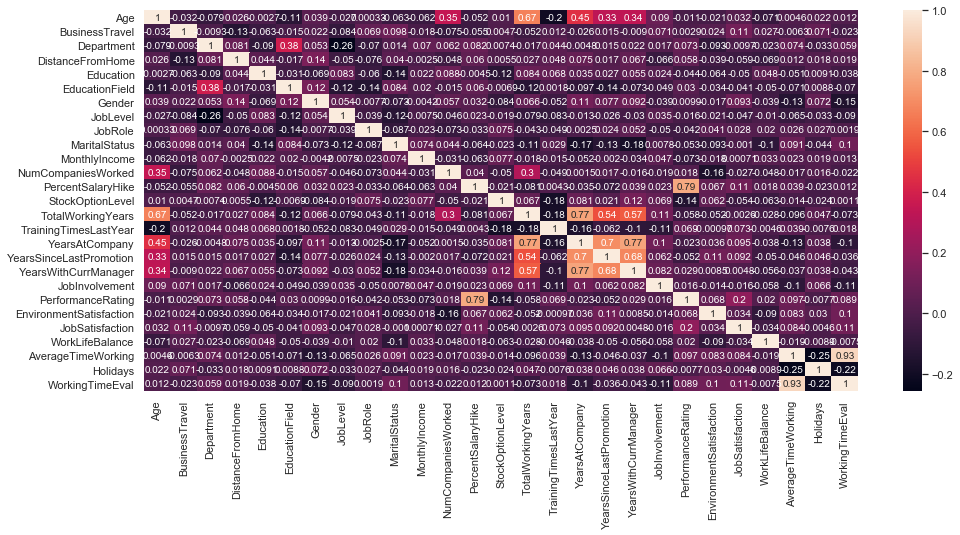

In [26]:
corr_cols_left = combinedLeftNum.copy()
corr_cols_left = corr_cols_left.drop(columns=['Attrition','StandardHours'])
corr_left = corr_cols_left.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr_left, annot=True)
plt.show()

In [27]:
corr_left

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
Age,1.000000,-0.031639,-0.079477,0.026080,-0.002747,-0.113001,0.038949,-0.026623,0.000335,-0.062643,...,0.329246,0.336577,0.089738,-0.011435,-0.021454,0.032429,-0.070672,0.004591,0.021912,0.012456
BusinessTravel,-0.031639,1.000000,-0.009269,-0.129196,-0.062701,-0.014534,0.022099,-0.083660,0.069251,0.097859,...,0.015419,-0.009043,0.071107,0.002915,0.024152,0.113666,0.027129,-0.006272,0.071240,-0.022848
Department,-0.079477,-0.009269,1.000000,0.081168,-0.090357,0.382773,0.052780,-0.256658,-0.070102,0.013892,...,0.015218,0.022124,0.017265,0.072812,-0.093000,-0.009682,-0.022756,0.073880,-0.032501,0.059491
DistanceFromHome,0.026080,-0.129196,0.081168,1.000000,0.043613,-0.016573,0.138646,-0.050439,-0.076234,0.039511,...,0.017294,0.067275,-0.065740,0.058141,-0.038527,-0.058820,-0.068935,0.011833,0.018249,0.019340
Education,-0.002747,-0.062701,-0.090357,0.043613,1.000000,-0.031414,-0.068516,0.083130,-0.060351,-0.144655,...,0.027004,0.055368,0.024253,-0.043840,-0.064351,-0.050108,0.048325,-0.050868,0.009095,-0.038368
EducationField,-0.113001,-0.014534,0.382773,-0.016573,-0.031414,1.000000,0.122581,-0.119812,-0.135301,0.084033,...,-0.135996,-0.072884,-0.048609,0.029988,-0.034416,-0.040693,-0.050066,-0.070527,0.008823,-0.069611
Gender,0.038949,0.022099,0.052780,0.138646,-0.068516,0.122581,1.000000,0.054154,-0.007680,-0.073219,...,0.077193,0.092273,-0.039035,0.009892,-0.016942,0.093105,-0.039115,-0.130735,0.071961,-0.150140
JobLevel,-0.026623,-0.083660,-0.256658,-0.050439,0.083130,-0.119812,0.054154,1.000000,-0.038666,-0.119772,...,-0.026023,-0.030132,0.034925,-0.016436,-0.020516,-0.047144,-0.010219,-0.065431,-0.033289,-0.089760
JobRole,0.000335,0.069251,-0.070102,-0.076234,-0.060351,-0.135301,-0.007680,-0.038666,1.000000,-0.086725,...,0.024282,0.052354,-0.049649,-0.042332,0.041299,0.028026,0.019536,0.026320,0.026980,0.001920
MaritalStatus,-0.062643,0.097859,0.013892,0.039511,-0.144655,0.084033,-0.073219,-0.119772,-0.086725,1.000000,...,-0.127911,-0.180062,0.007763,-0.052990,-0.092527,-0.001047,-0.103517,0.090822,-0.043669,0.104897


Nous pouvons constater que certaines données semblent liées fortement, notamment ce qui tourne autour de l'expérience de l'employé (Age, TotalWorkingYears, YearsAtCompany,YearsSinceLastPromotion, YearsWithCurrManager). On note également un lien entre le PerformanceRating et le PercentSalaryHike.

Faisons quelques graphes afin de voir si quoi que ce soit est notable visuellement.

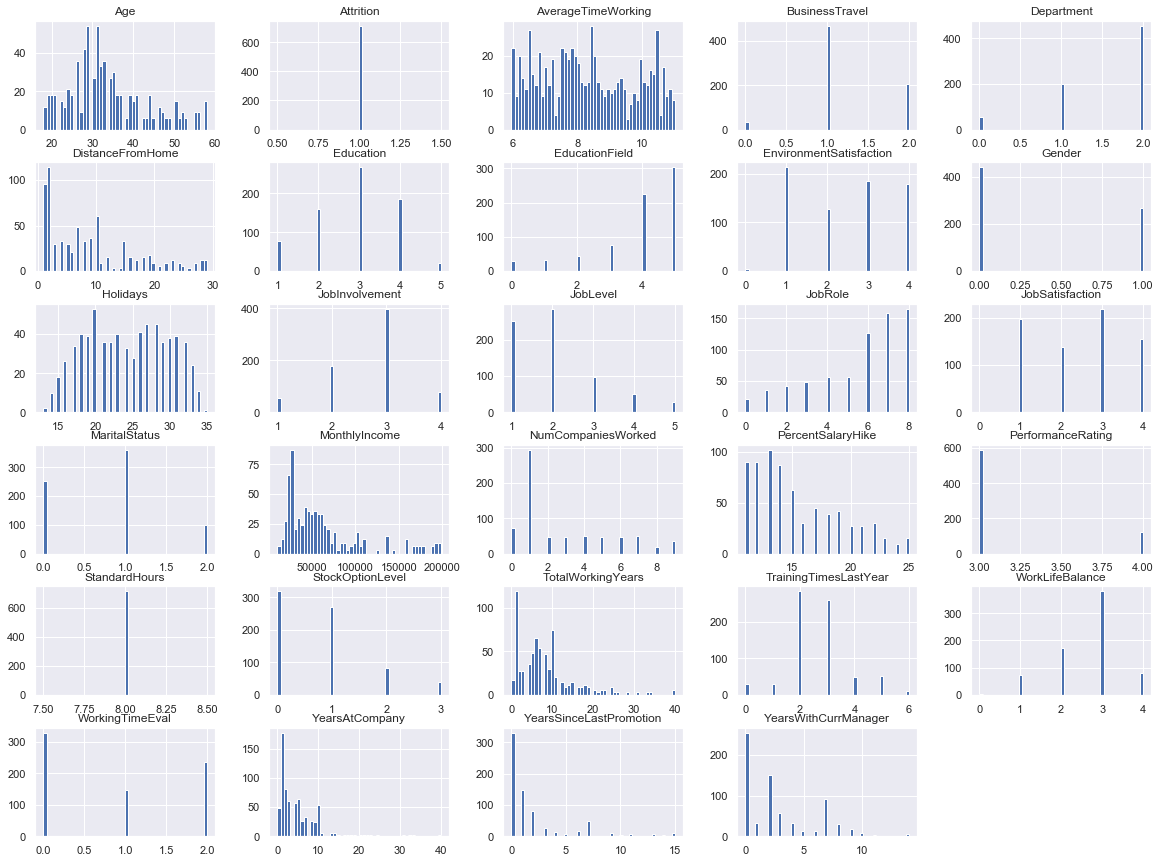

In [28]:
combinedLeftNum.hist(bins=50, figsize=(20,15))
plt.show()

### Étude des employés restés en 2016

Nous allons effectuer à nouveau les mêmes démarches avec l'autre groupe.

In [29]:
combinedStayNum = combinedStay.copy()
combinedStayNum.reset_index(drop=True, inplace=True)
combinedStayNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
2,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
3,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
4,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,Female,4,Research Director,...,7,7,3,3,3.0,2.0,2.0,10.796111,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,42,No,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
3695,29,No,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
3696,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,Male,2,Sales Executive,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
3697,42,No,Travel_Rarely,Sales,18,2,Medical,Male,1,Laboratory Technician,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


In [30]:
combinedStayNum['Attrition'] = combinedStayNum['Attrition'].map(diAttrition)
combinedStayNum['BusinessTravel'] = combinedStayNum['BusinessTravel'].map(diBusinessTravel)
combinedStayNum['Department'] = combinedStayNum['Department'].map(diDepartment)
combinedStayNum['EducationField'] = combinedStayNum['EducationField'].map(diEducationField)
combinedStayNum['JobRole'] = combinedStayNum['JobRole'].map(diJobRole)
combinedStayNum['Gender'] = combinedStayNum['Gender'].map(diGender)
combinedStayNum['MaritalStatus'] = combinedStayNum['MaritalStatus'].map(diMaritalStatus)

In [31]:
combinedStayNum

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,0,1,1,6,2,5,1,1,4,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,32,0,2,2,17,4,0,0,4,8,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
2,38,0,0,2,2,5,5,0,3,0,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
3,32,0,1,2,10,1,4,0,1,8,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
4,46,0,1,2,8,3,5,1,4,5,...,7,7,3,3,3.0,2.0,2.0,10.796111,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,42,0,1,2,5,4,4,1,1,7,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
3695,29,0,1,2,2,4,4,0,1,6,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
3696,25,0,1,2,25,2,5,0,2,8,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
3697,42,0,1,1,18,2,4,0,1,6,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


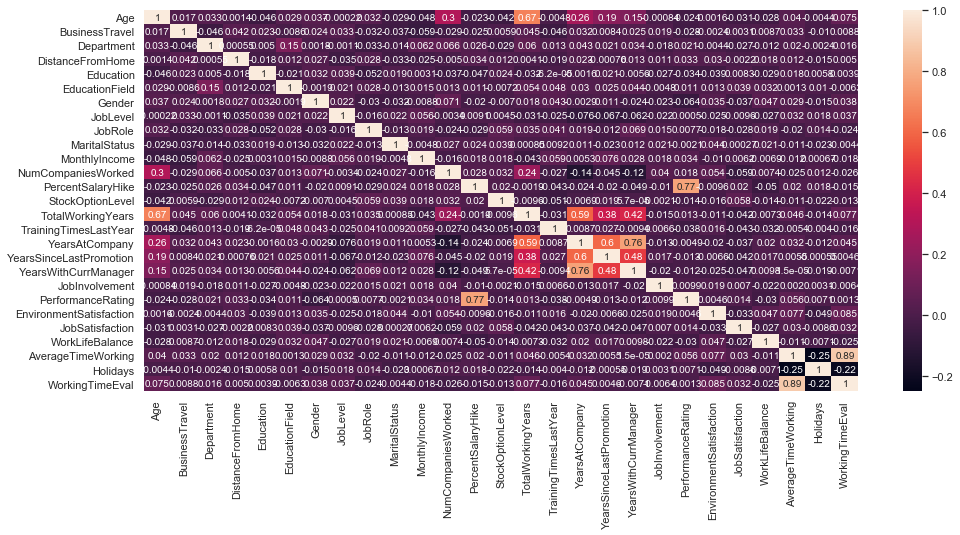

In [32]:
corr_cols_stay = combinedStayNum.copy()
corr_cols_stay = corr_cols_stay.drop(columns=['Attrition','StandardHours'])
corr_stay = corr_cols_stay.corr()
plt.figure(figsize=(16,7))
sns.heatmap(corr_stay, annot=True)
plt.show()

On remarque qu'ici aussi, on trouve une certaine corrélation entre certaines données dans le même cadre que pour le groupe des employés partis. Cela voudrait dire que ces corrélations ne sont pas spécifiques aux employés partis.

In [33]:
corr_stay

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
Age,1.000000,0.017109,0.032983,0.001396,-0.046052,0.028615,0.036557,-0.000221,0.032073,-0.029400,...,0.190892,0.154146,-0.000843,-0.024495,0.001551,-0.030783,-0.027873,0.040328,-0.004375,0.075348
BusinessTravel,0.017109,1.000000,-0.045847,0.042255,0.023452,-0.008553,0.024251,0.033362,-0.031718,-0.036523,...,0.008378,0.024981,0.018808,-0.028041,-0.002396,0.003070,0.008725,0.033285,-0.010360,0.008841
Department,0.032983,-0.045847,1.000000,0.000547,0.005003,0.148526,0.001845,-0.001058,-0.033220,-0.013950,...,0.021496,0.034477,-0.018487,0.020788,-0.004373,-0.026923,-0.011912,0.019683,-0.002354,0.016361
DistanceFromHome,0.001396,0.042255,0.000547,1.000000,-0.018253,0.011902,0.026899,-0.035182,0.028390,-0.032544,...,-0.000756,0.012829,0.010658,0.032533,0.030190,-0.002199,0.018342,0.011621,-0.014554,0.005038
Education,-0.046052,0.023452,0.005003,-0.018253,1.000000,-0.021087,0.032208,0.038853,-0.051656,0.018815,...,0.021082,-0.005641,-0.027352,-0.033538,-0.038791,0.008295,-0.029197,0.017518,0.005752,0.003854
EducationField,0.028615,-0.008553,0.148526,0.011902,-0.021087,1.000000,-0.001937,0.020819,0.028083,-0.012690,...,0.025440,0.043811,-0.004818,0.011232,0.012592,0.039278,0.031574,0.001267,0.010118,-0.006287
Gender,0.036557,0.024251,0.001845,0.026899,0.032208,-0.001937,1.000000,0.021730,-0.029731,-0.032278,...,0.010875,-0.023907,-0.023399,-0.063504,0.035110,-0.037341,0.047304,0.028954,-0.014631,0.038413
JobLevel,-0.000221,0.033362,-0.001058,-0.035182,0.038853,0.020819,0.021730,1.000000,-0.016308,0.021792,...,-0.067420,-0.061955,-0.022242,0.000502,-0.024546,-0.009579,-0.026820,0.031583,0.018310,0.036574
JobRole,0.032073,-0.031718,-0.033220,0.028390,-0.051656,0.028083,-0.029731,-0.016308,1.000000,-0.012695,...,-0.011591,0.068632,0.014757,0.007748,-0.018175,-0.027859,0.018747,-0.020388,0.014324,-0.023980
MaritalStatus,-0.029400,-0.036523,-0.013950,-0.032544,0.018815,-0.012690,-0.032278,0.021792,-0.012695,1.000000,...,-0.022513,0.011509,0.021037,-0.002065,0.043613,0.000269,0.021255,-0.011489,-0.023418,-0.004391


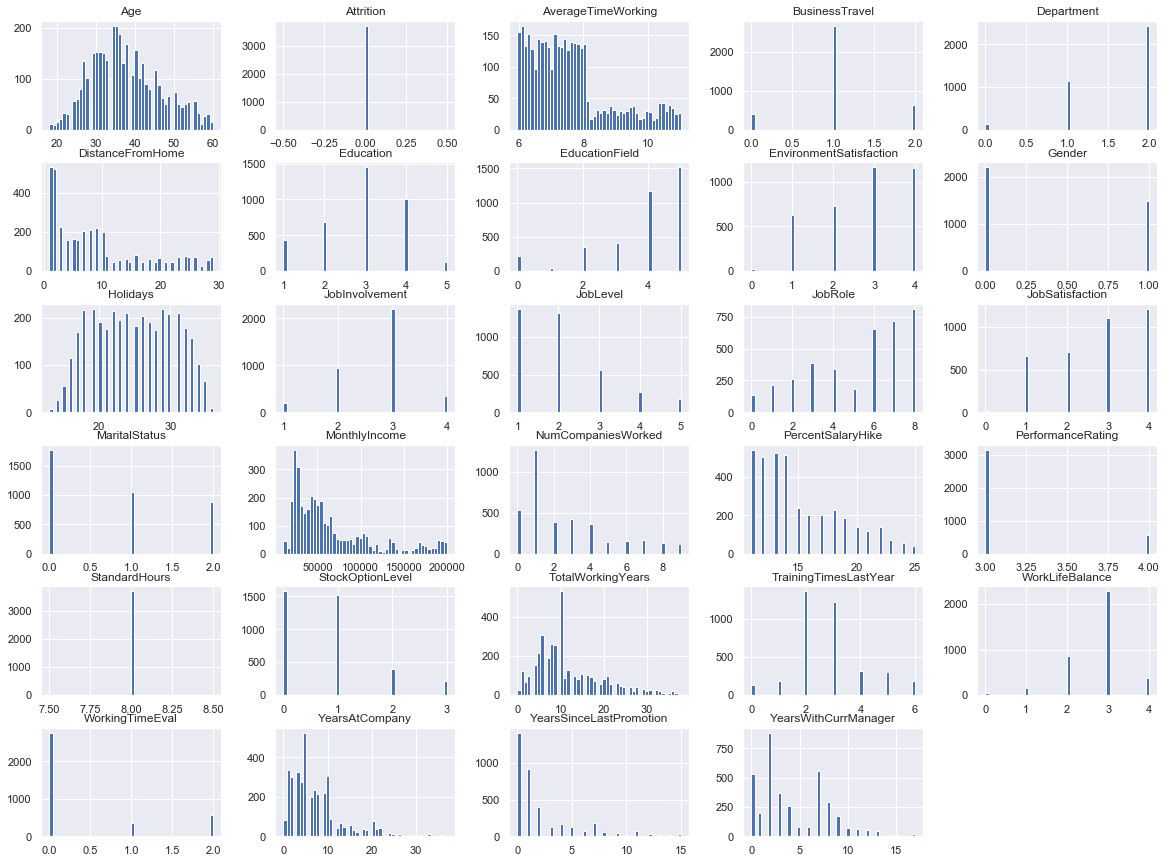

In [34]:
combinedStayNum.hist(bins=50, figsize=(20,15))
plt.show()

### Comparaison des deux groupes

Nous allons maintenant comparer nos résultats sur les deux groupes afin de voir si certains sont spécifiques à leur groupe.

On remarque rapidement que toutes les corrélations ne sont pas uniques au groupe. 
En effet, les corrélations notables parmis les employés partis sont: 
  - TotalWorkingYears / Âge --- 0.67
  - TotalWorkingYears / YearsAtCompany --- 0.77
  - PercentSalaryHike / PerformanceRating --- 0.79
  - YearsSinceLastPromotion / YearsAtCompany --- 0.7
  - YearsWithCurrManager / YearsAtCompany --- 0.77
  - AverageWorkingTime / WorkingTimeEval ---0.93

Chez les employés restés, on retrouve gloablement les mêmes corrélations.
Ces relations en commun ne peuvent donc pas nous donner d'informations sur les employés partis. Cela est d'ailleurs logique: nous avons à chaque fois une corrélation positive ce qui correspond aux données. En effet, le nombre total d'années travaillées augmente avec l'âge et vice-versa (la plupart du temps). On peut faire la même réflexion pour les autres relations.

Par conséquent, une simple étude statistique n'est pas suffisante, et nous devons donc tenter d'utiliser un ou plusieurs modèles de Machine Learning afin de pouvoir être capable d'iendtifier les comployés susceptibles de partir.

# Modèles de Machine Learning

## KNN: K-Nearest Neighbors

Nous allons tenter de voir si l'algorithme des K plus proches voisins (KNN) peut fournir des résultats acceptables.

Pour cela, nous allons lui fournir un set d'entrainement puis un set de test, et nous étudierons sa précisions et ses métriques.

In [35]:
dataSetKNN = combined_csv.copy()
dataSetKNN

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,Male,2,Sales Executive,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
4408,42,No,Travel_Rarely,Sales,18,2,Medical,Male,1,Laboratory Technician,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


Pour rendre nos données manipulables par l'algorithme KNN, il nous faut des valrus numériques. Nous allons donc répéter l'opération faite précédemment. 

In [36]:
dataSetKNN['Attrition'] = dataSetKNN['Attrition'].map(diAttrition)
dataSetKNN['BusinessTravel'] = dataSetKNN['BusinessTravel'].map(diBusinessTravel)
dataSetKNN['Department'] = dataSetKNN['Department'].map(diDepartment)
dataSetKNN['EducationField'] = dataSetKNN['EducationField'].map(diEducationField)
dataSetKNN['JobRole'] = dataSetKNN['JobRole'].map(diJobRole)
dataSetKNN['Gender'] = dataSetKNN['Gender'].map(diGender)
dataSetKNN['MaritalStatus'] = dataSetKNN['MaritalStatus'].map(diMaritalStatus)
print(dataSetKNN.dtypes)

Age                          int64
Attrition                    int64
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField               int64
Gender                       int64
JobLevel                     int64
JobRole                      int64
MaritalStatus                int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
AverageTimeWorking         float64
Holidays                     int64
WorkingTimeEval     

In [37]:
dataSetKNN

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
0,51,0,1,1,6,2,5,1,1,4,...,0,0,3,3,3.0,4.0,2.0,7.373611,29,0
1,31,1,2,2,10,1,5,1,1,7,...,1,4,2,4,3.0,2.0,4.0,7.718889,25,0
2,32,0,2,2,17,4,0,0,4,8,...,0,3,3,3,2.0,2.0,1.0,7.013056,19,0
3,38,0,0,2,2,5,5,0,3,0,...,7,5,2,3,4.0,4.0,3.0,7.193611,26,0
4,32,0,1,2,10,1,4,0,1,8,...,0,4,3,3,4.0,1.0,3.0,8.005833,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0,1,2,5,4,4,1,1,7,...,0,2,3,3,4.0,1.0,3.0,8.522222,18,1
4406,29,0,1,2,2,4,4,0,1,6,...,0,2,2,3,4.0,4.0,3.0,6.092778,20,0
4407,25,0,1,2,25,2,5,0,2,8,...,1,2,3,4,1.0,3.0,3.0,7.706667,30,0
4408,42,0,1,1,18,2,4,0,1,6,...,7,8,2,3,4.0,1.0,3.0,9.492778,20,2


Il nous faut maintenant constituer un DataSet d'entrainement pour notre algorithme.

In [38]:
y = dataSetKNN.Attrition
x = dataSetKNN.drop('Attrition',axis=1)

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
2586,58,1,1,5,3,3,0,5,1,0,...,0,0,3,4,4.0,4.0,2.0,9.880833,26,2
1688,24,1,1,7,3,4,1,1,6,0,...,0,0,1,3,4.0,2.0,3.0,6.786667,19,0
3726,49,1,2,7,3,5,0,3,6,0,...,1,2,1,3,1.0,3.0,2.0,6.816667,33,0
3295,34,1,1,2,5,5,0,4,7,0,...,0,2,3,3,3.0,0.0,1.0,6.877778,29,0
3131,39,2,2,12,1,4,0,1,7,0,...,0,7,3,3,3.0,3.0,3.0,7.065000,22,0


In [40]:
x_test.shape

(882, 28)

Ensuite, nous allons effectuer du Feature Scaling. 

En effet, le KNN va calculer les distances euclidiennes entre chaque point et s'en servir pour ses prédictions. Pour cela, il faut normaliser les données afin de donner le même "poids" à chaque donnée.

In [41]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Ensuite, nous pouvons initialiser notre Classifier KNN avec sklearn.

K (ou n_neighbors, comprise entre 1 et 40) correspond au nombres de voisins que l'on va considérer à chaque itération. La valeure utilisée par défaut le plus souvent est 5.

Il est important de noter que plus la valeur de K est élevée, plus l'algorithme tente d'être précis, mais plus cela peut avoir d'impact sur l'erreur moyenne absolue. Cela dépend du type de problème et des données utilisées, il faudra donc étudier cela en détails.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [43]:
y_pred = classifier.predict(x_test)

On teste la précision.
Ici : **precision** correspond au rapport de "vrai positifs" sur le total de positifs, et **recall** correpond au rapport de "vrai positifs" sur le nombre total d'éléments.
Le **f1-score** est calculé à partir de ces deux valeurs.

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[706  38]
 [ 87  51]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       744
           1       0.57      0.37      0.45       138

    accuracy                           0.86       882
   macro avg       0.73      0.66      0.68       882
weighted avg       0.84      0.86      0.85       882



Nous obtenons une précision de 87% ce qui semble être plus qu'acceptable, cependant la valeur faible de K laisse à penser que cela n'est pas forcément réaliste par rapport aux données fournies.

Nous allons donc regarder comment la valeur de K influence le taux d'erreur, et nous baser dessus.

In [45]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

On affiche l'erreur moyenne absolue en fonction des valeurs de K.

Text(0, 0.5, 'Mean Error')

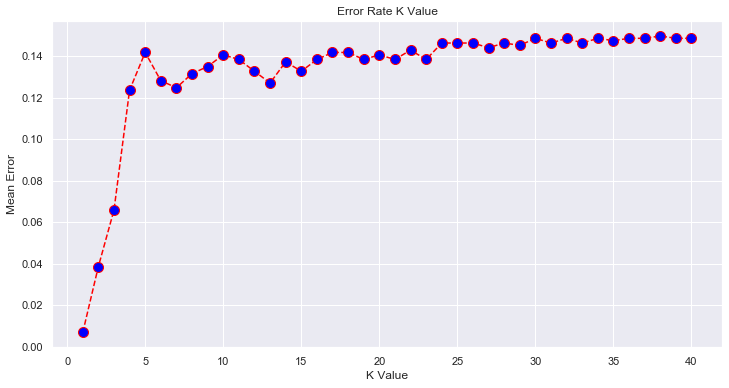

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 41), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

On remarque ici que pour des valeurs de K faibles, l'erreur moyenne absolue est certes plus faible mais l'étude possède moins de valeurs, et l'on se rapproche plus du sous-apprentissage car l'algorithme ne considère qu'une infime partie des données à chaque itération.

Cependant, on remarque agréablement que pour des valeurs de K plus élevées, le taux d'erreur se stabilise.

Afin d'obtenir un résultat optimal, nous pouvons donc choisir la valeur de K la plus élevée pour laquelle l'erreur moyenne absolue est la plus basse, à partir du moment où tout est stabilisé.

Nous choisissons donc K=19.

In [47]:
from sklearn.neighbors import KNeighborsClassifier
classifier2 = KNeighborsClassifier(n_neighbors=19)
classifier2.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [48]:
y_pred2 = classifier2.predict(x_test)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

[[737   7]
 [115  23]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       744
           1       0.77      0.17      0.27       138

    accuracy                           0.86       882
   macro avg       0.82      0.58      0.60       882
weighted avg       0.85      0.86      0.82       882



Si l'on considère toutes les données, l'algorithme KNN a au mieux une précision de 86%, ce qui reste assez proche du résultat précédent, mais avec une valeur de K plus grande.

#### Interprétation des résultats

Notre modèle possède donc une précision de 86%. Regardons concrêtement ce que cela représente.

Supposons que lorsque notre modèle identifie un employé susceptible de partir, l'entreprise arrive à le convaincre de rester.

Dans les données fournies, nous avions un total de 4410 employés. Sur ces 4410 employés, 711 sont partis tandis que les 3699 restant sont restés dans l'entreprise. Si nous avions utilisé notre modèle à ce moment là, nous aurions identifier 86% des employés qui allaient partir, c'est-à-dire environ 611 personnes. 

Le problème de l'entreprise étant la recherche de profils similaires à ceux ayant quittés l'entreprise, les Ressources Humaines n'auraient qu'à cherche qu'une centaine de profils contre plus de 700. Cela représente un gain de temps et de moyens considérables. 

Cependant, il reste important de noter que pour des échantillons plus grands, notre modèle, bien qu'ayant une précision de 86%, se révèlera insuffisant concrêtement par rapport à la charge de travil qu'il peut aider à supprimer. 

Il nous faudrait donc des set de données sur plusieurs années afin de voir la quantité d'employés qui sont partis. Si chaque année l'échantillon reste de taille similaire aux données que nous avons eu, alors ce modèle peut fournir des convenables. Si cependant on remarque que dans certains cas, la proportion d'employés partis est beaucoup plus élevée, trouver un modèle encore plus précis, aux alentours de 95% idéalement, serai à envisager.

# Forêt d'arbres décisionnels

Suite à l'algorithm KNN, nous allons réaliser un algorithme de forêts d'arbres décisionnels pour notre cas d'étude afin de voir si il est plus pertinent ou non que celui de KNN.

Pour cela nous allons reprendre le même set d'entraînement que celui du KNN

In [51]:
dataSetForest = dataSetKNN.copy()

y = dataSetForest.Attrition
x = dataSetForest.drop('Attrition',axis=1)

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2)
x_train.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays,WorkingTimeEval
1400,34,2,0,7,4,0,1,1,7,0,...,1,9,4,3,4.0,3.0,2.0,6.800556,34,0
3593,25,2,2,1,1,5,0,1,3,1,...,1,0,3,3,3.0,4.0,3.0,9.216944,16,2
4117,44,1,2,8,1,5,1,1,1,1,...,1,2,3,3,2.0,4.0,3.0,10.798889,25,2
2954,28,1,2,1,3,5,0,1,3,0,...,0,4,3,3,4.0,4.0,2.0,6.066944,35,0
834,45,1,1,3,3,5,0,3,6,0,...,0,3,2,4,4.0,4.0,3.0,6.044722,22,0


In [52]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Testons d'abord avec un arbre unique avant de réaliser la forêt:

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

On calcule la rmse pour savoir une idée de la performance de notre modèle. La RMSE (root mean square deviation) est une mesure de précision, elle permet de comparer les erreurs de prédictions:

In [57]:
from sklearn.metrics import mean_squared_error
work_predictions = tree_reg.predict(x_train)
tree_mse = mean_squared_error(y_train, work_predictions)
tree_rmse = np.sqrt(tree_mse)
print("RMSE: ",tree_rmse) 

RMSE:  0.0


On tombe sur un cas de sur-apprentissage. Cela signifie que notre modèle est trop puissant et s'est contenté d'apprendre notre jeu de donnée par coeur. On va donc passer par une validation croisé pour éviter le cas de sur-apprenstissage. 

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.23200078 0.24964564 0.14081913 0.18450624 0.23520023]
Mean: 0.20843440585318235
Standard deviation: 0.04028531127171653


On s'aperçoit que c'est un très bon résultat, ce qui est prometteur. En effet, la moyenne de l'erreur type est de 0.208 !
Testons maintenant avec une forêt:

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor( n_estimators=10, random_state=42)
forest_reg.fit(x_train, y_train)

work_predictions = forest_reg.predict(x_train)
forest_mse = mean_squared_error(y_train, work_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE: ",forest_rmse)

RMSE:  0.06687891383422923


In [64]:
forest_scores = cross_val_score(forest_reg, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.214225   0.21682097 0.18033648 0.17336879 0.19288772]
Mean: 0.19552779259412484
Standard deviation: 0.017502869149556264


On peut voir une légère amélioration, on est passé d'une moyenne de l'erreur type à 0.208 à 0.196. Mais on peut toujours remarquer que la différence avant et après la cross validation est importante (RMSE = 0.07, Mean = 0.196).  
A présent calculons la précision de notre algorithme comme nous l'avons fait pour le modèle KNN:

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = forest_reg.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Nous recevons cette erreur lorsque nous tentons d'afficher la précision de notre modèle. Après plusieurs recherche et grâce a la réponse de cette internaute (https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target), On a pu déterminer que non la raison pour laquelle la précision ou le recall n'était pas possible n'est pas un problème de données mais simplement que ce modèle n'est pas adapté pour notre cas d'études. En effet nous tentons de comparer des données binaires (si l'employé à oui ou non quitté l'entreprise) et des données non binaires comme le nombre d'heures qu'il travaille en moyenne. L'internaute prend en exemple c'est comme comparer des pommes et des oranges, c'est un problème théorique et non numérique. La forêt d'abres décisionnel de regression (que nous utilisons) n'est pas capable de réaliser une classification, ce qui est lié à notre étude de cas.

Pour cela nous allons utiliser une forêt d'abre de classification aka RandomForestClassifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_clas = RandomForestClassifier( n_estimators=10, random_state=42)
forest_clas.fit(x_train, y_train)

work_predictions = forest_clas.predict(x_train)
forest_clas_mse = mean_squared_error(y_train, work_predictions)
forest_clas_rmse = np.sqrt(forest_clas_mse)
print("RMSE: ",forest_clas_rmse)

RMSE:  0.016835875742536845


In [71]:
forest_clas_scores = cross_val_score(forest_clas, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_clas_rmse_scores = np.sqrt(-forest_clas_scores)
display_scores(forest_clas_rmse_scores)

Scores: [0.21289852 0.24679245 0.21289852 0.19928952 0.19928952]
Mean: 0.21423370543124842
Standard deviation: 0.017379844958177737


On peut voir une meilleur RMSE que les deux autres modèle de forêt et d'abre, cependant une moyenne d'erreur type légèrement plus grande mais minime tout de même.

A présent que nous utilisons un modèle capable de classification on peut afficher la précision pour voir l'efficacité de notre modèle:

In [72]:
y_pred = forest_clas.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[738   4]
 [  8 132]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.94      0.96       140

    accuracy                           0.99       882
   macro avg       0.98      0.97      0.97       882
weighted avg       0.99      0.99      0.99       882

0.9863945578231292


Nous avons 98.6% de précision ! Ce qui est un scrore très positif et meilleur que celui obtenu avec le modèle KNN.

Cependant comme le modèle KNN, nous avons une variable qui potentiellement influe sur la précision de notre modèle. Ici 'n_estimators' correspont au nombre d'arbre que possède notre forêt. Nous allons donc faire varier ce nombre de 1 à 40 et aficher le résultat sous forme de graphique.

In [74]:
f_error = []

# Calculating error for tree values between 1 and 40
for i in range(1, 41):
    f_clas = RandomForestClassifier( n_estimators=i, random_state=42)
    f_clas.fit(x_train, y_train)
    f_pred_i = f_clas.predict(x_test)
    f_error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

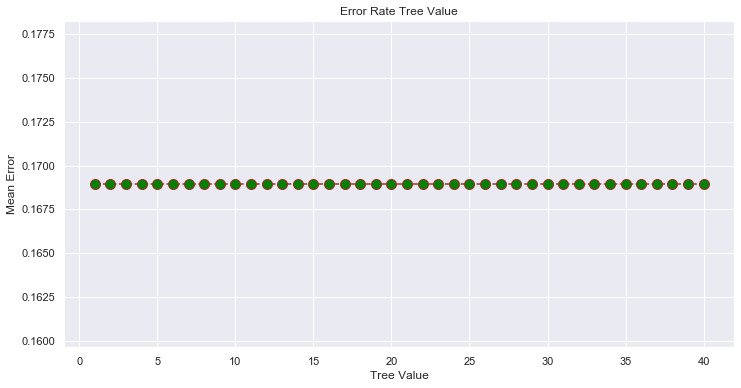

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 41), f_error, color='brown', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=10)
plt.title('Error Rate Tree Value')
plt.xlabel('Tree Value')
plt.ylabel('Mean Error')

On peut donc voir que l'erreur type ne varie pas en modifiant le nombre d'arbre que possède notre forêt. Ce qui indique que notre modèle est bien précis à 98.6% et de manière constante.